# Librerias

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


# Funciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata


# Cargar datos

## Generar imagenes con 3 canales

In [3]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [8]:
s = 64
#folder = "/work/work_teamEXOPLANET/"
folder = "/media/mbugueno/Respaldo/KOI_LC/MTF/"


In [10]:
#channel_1 = np.load(folder+'/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(s,s))  
#channel_2 = np.load(folder+'/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(s,s))  
#channel_3 = np.load(folder+'/MTF_gabo/npys/MTF_time_u%d_d%d.npy'%(s,s))  

channel_1 = np.load(folder+'/normal/MTF_u%d_d%d.npy'%(s,s))  
channel_2 = np.load(folder+'/invertidos/MTF_u%d_d%d.npy'%(s,s))  
channel_3 = np.load(folder+'/time/MTF_time_u%d_d%d.npy'%(s,s))  
channel_1.shape

(8054, 128, 128)

### Markov cubo, hasta 10 canales

In [6]:
channel_1 = np.load(folder+'MTF_gN/no_invertidos/MTF_u%d_d%d.npy'%(s,s))  
channel_2 = np.load(folder+'MTF_gN/invertidos/MTF_u%d_d%d.npy'%(s,s))  

In [7]:
print(channel_1.shape)
print(channel_2.shape)
print(channel_3.shape)

(8054, 32, 32, 10)
(8054, 32, 32, 10)
(8054, 32, 32)


###### 1 canales (con varios grados) + data augm

In [7]:
n = 3

x_all = channel_1[:,:,:,:n]

x_all2 = channel_2[:,:,:,:n]

In [8]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i,:,:,:n],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i,:,:,:n], channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

###### 2 canales (sin tiempo)

In [7]:
'''x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)'''

'x_all = []\nfor i in range(channel_1.shape[0]):\n    combined_image = np.dstack((channel_1[i],channel_2[i]))\n    x_all.append(combined_image)\nx_all = np.asarray(x_all)'

###### 2 canales (arriba) + data augm

In [11]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i],channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

## Generar conjunto de entrenamiento y validación

In [12]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [13]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [14]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [12]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 32, 32, 4) (4339,)
Objetos de validación: (1918, 32, 32, 4) (1918,)


###### 2 canales (arriba) + data augm

In [15]:
x_train1 = x_all[mask_train]
x_train2 = x_all2[mask_train]
x_train = np.concatenate([x_train1,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 128, 128, 2) (8678,)
Objetos de validación: (1918, 128, 128, 2) (1918,)


## pre-process

In [21]:
x_train = np.log(x_train)
x_val = np.log(x_val)

### Experimentos FMEna - f1 score

In [16]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        prob = self.model.predict(self.validation_data[0])
        predict = np.squeeze(prob>=0.5)*1
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

## Modificaciones
* guarda el mejor modelo (pesos) en base a val loss random (10%)

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
__________

In [19]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11373000775869848354]

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [18]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

Train on 7810 samples, validate on 868 samples
Epoch 1/200
4608/7810 [================>.............] - ETA: 25s - loss: 0.6369 - acc: 0.6385

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-25af2d9a6435>", line 1, in <module>
    train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model
  File "<ipython-input-16-607bcfa66901>", line 60, in train_model
    callbacks=calls)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/keras/models.py", line 1002, in fit
    validation_steps=validation_steps)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/keras/engine/training.py", line 1705, in fit
    validation_steps=validation_steps)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/keras/engine/training.py", line 1236, in _fit_loop
    outs = f(ins_batch)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/keras/backend/tensorfl

KeyboardInterrupt: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.780619,0.930233,0.848884,0.770758,0.737225,0.784672
Confirmed,0.798611,0.514158,0.625567,0.770758,0.737225,0.784672


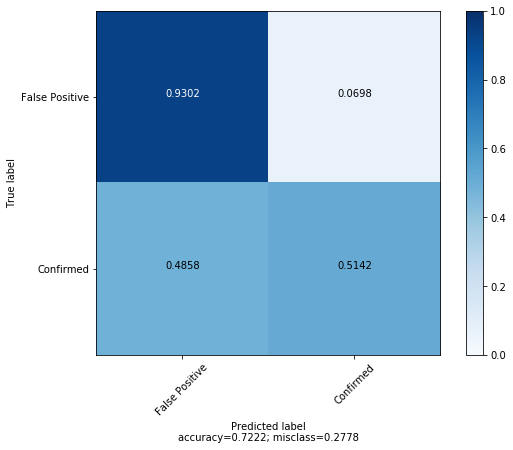

{'Precision raw': array([0.78061911, 0.79861111]),
 'Recall raw': array([0.93023256, 0.51415797]),
 'F1 raw': array([0.84888401, 0.62556664]),
 'F1 weighted': 0.7707578591402544,
 'F1 macro': 0.737225323345604,
 'F1 micro': 0.7846715328467153,
 'Confusion Matrix': array([[1160,   87],
        [ 326,  345]])}

In [24]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         73856     
__________

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 609us/step - loss: 0.7025 - acc: 0.6230 - val_loss: 0.6073 - val_acc: 0.6290
Epoch 2/200
7810/7810 [==============================] - 3s 358us/step - loss: 0.5815 - acc: 0.6259 - val_loss: 0.6087 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 3s 377us/step - loss: 0.5692 - acc: 0.6319 - val_loss: 0.5922 - val_acc: 0.6452
Epoch 4/200
7810/7810 [==============================] - 3s 359us/step - loss: 0.5655 - acc: 0.6369 - val_loss: 0.5901 - val_acc: 0.5876
Epoch 5/200
7810/7810 [==============================] - 3s 341us/step - loss: 0.5556 - acc: 0.6370 - val_loss: 0.6409 - val_acc: 0.5415
Epoch 6/200
7810/7810 [==============================] - 3s 372us/step - loss: 0.5613 - acc: 0.6341 - val_loss: 0.5767 - val_acc: 0.5933
Epoch 7/200
7810/7810 [==============================] - 3s 367us/step - loss: 0.5480 - acc: 0.6321 - val_loss: 0.5674 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 3s 336us/step - loss: 0.5108 - acc: 0.6864 - val_loss: 0.5255 - val_acc: 0.6509
Epoch 36/200
7810/7810 [==============================] - 3s 330us/step - loss: 0.5025 - acc: 0.6944 - val_loss: 0.5362 - val_acc: 0.6486
Epoch 37/200
7810/7810 [==============================] - 3s 397us/step - loss: 0.5389 - acc: 0.6711 - val_loss: 0.5316 - val_acc: 0.6993
Epoch 38/200
7810/7810 [==============================] - 3s 379us/step - loss: 0.5259 - acc: 0.6690 - val_loss: 0.5225 - val_acc: 0.7039
Epoch 39/200
7810/7810 [==============================] - 3s 347us/step - loss: 0.5174 - acc: 0.6826 - val_loss: 0.5219 - val_acc: 0.6889
Epoch 40/200
7810/7810 [==============================] - 3s 343us/step - loss: 0.5169 - acc: 0.6869 - val_loss: 0.5272 - val_acc: 0.6671
Epoch 41/200
7810/7810 [==============================] - 3s 338us/step - loss: 0.5257 - acc: 0.6726 - val_loss: 0.5539 - val_acc: 0.6382
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 3s 340us/step - loss: 0.4835 - acc: 0.7133 - val_loss: 0.4853 - val_acc: 0.7051
Epoch 104/200
7810/7810 [==============================] - 3s 342us/step - loss: 0.4858 - acc: 0.7028 - val_loss: 0.4999 - val_acc: 0.6889
Epoch 105/200
7810/7810 [==============================] - 3s 336us/step - loss: 0.4760 - acc: 0.7215 - val_loss: 0.4980 - val_acc: 0.6797
Epoch 106/200
7810/7810 [==============================] - 3s 336us/step - loss: 0.4804 - acc: 0.7133 - val_loss: 0.4950 - val_acc: 0.6993
Epoch 107/200
7810/7810 [==============================] - 3s 333us/step - loss: 0.4737 - acc: 0.7216 - val_loss: 0.5066 - val_acc: 0.6371
Epoch 108/200
7810/7810 [==============================] - 3s 331us/step - loss: 0.4740 - acc: 0.7179 - val_loss: 0.5057 - val_acc: 0.6659
Epoch 109/200
7810/7810 [==============================] - 3s 356us/step - loss: 0.4721 - acc: 0.7202 - val_loss: 0.5216 - val_acc: 0.6590
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 3s 337us/step - loss: 0.4430 - acc: 0.7557 - val_loss: 0.4857 - val_acc: 0.6970
Epoch 138/200
7810/7810 [==============================] - 3s 336us/step - loss: 0.4330 - acc: 0.7624 - val_loss: 0.4948 - val_acc: 0.6878
Epoch 139/200
7810/7810 [==============================] - 3s 331us/step - loss: 0.4817 - acc: 0.7117 - val_loss: 0.5032 - val_acc: 0.6601
Epoch 140/200
7810/7810 [==============================] - 3s 335us/step - loss: 0.4465 - acc: 0.7476 - val_loss: 0.5303 - val_acc: 0.6590
Epoch 141/200
7810/7810 [==============================] - 3s 347us/step - loss: 0.4480 - acc: 0.7487 - val_loss: 0.4710 - val_acc: 0.7039
Epoch 142/200
7810/7810 [==============================] - 3s 356us/step - loss: 0.4383 - acc: 0.7560 - val_loss: 0.4880 - val_acc: 0.6855
Epoch 143/200
7810/7810 [==============================] - 3s 370us/step - loss: 0.4361 - acc: 0.7597 - val_loss: 0.4705 - val_acc: 0.7062
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 3s 333us/step - loss: 0.4285 - acc: 0.7666 - val_loss: 0.4830 - val_acc: 0.6993
Epoch 172/200
7810/7810 [==============================] - 3s 331us/step - loss: 0.4224 - acc: 0.7656 - val_loss: 0.4902 - val_acc: 0.6843
Epoch 173/200
7810/7810 [==============================] - 3s 324us/step - loss: 0.4261 - acc: 0.7673 - val_loss: 0.4816 - val_acc: 0.6947
Epoch 174/200
7810/7810 [==============================] - 3s 353us/step - loss: 0.4256 - acc: 0.7677 - val_loss: 0.5001 - val_acc: 0.6728
Epoch 175/200
7810/7810 [==============================] - 3s 357us/step - loss: 0.4264 - acc: 0.7638 - val_loss: 0.5222 - val_acc: 0.6532
Epoch 176/200
7810/7810 [==============================] - 3s 340us/step - loss: 0.4312 - acc: 0.7620 - val_loss: 0.4708 - val_acc: 0.7005
Epoch 177/200
7810/7810 [==============================] - 3s 343us/step - loss: 0.4254 - acc: 0.7657 - val_loss: 0.5174 - val_acc: 0.6682
Epoch 178/200
7810/7810 [================

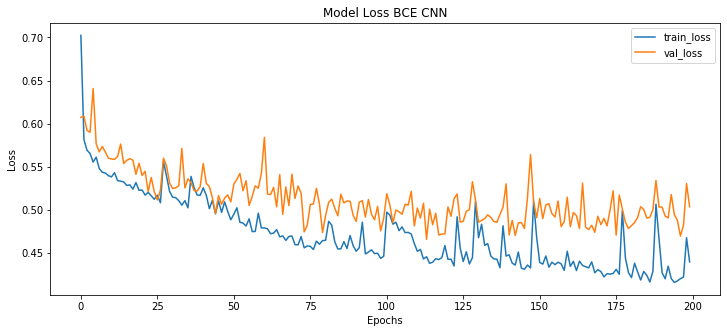

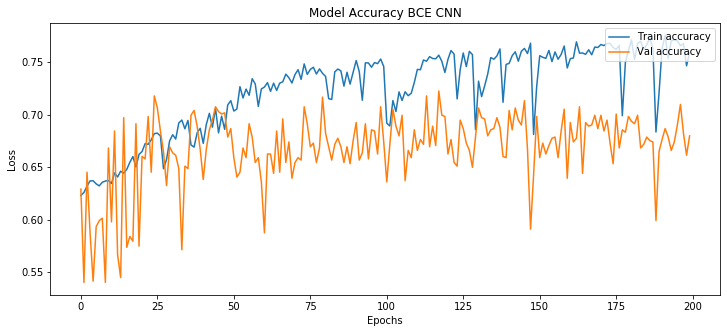

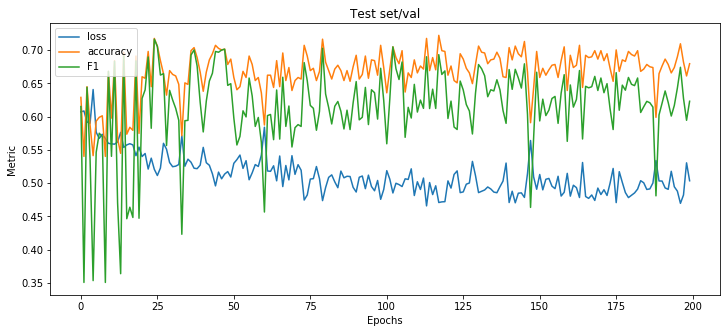

In [26]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         73856     
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.774490,0.944667,0.851156,0.76827,0.732694,0.785193
Confirmed,0.826196,0.488823,0.614232,0.76827,0.732694,0.785193


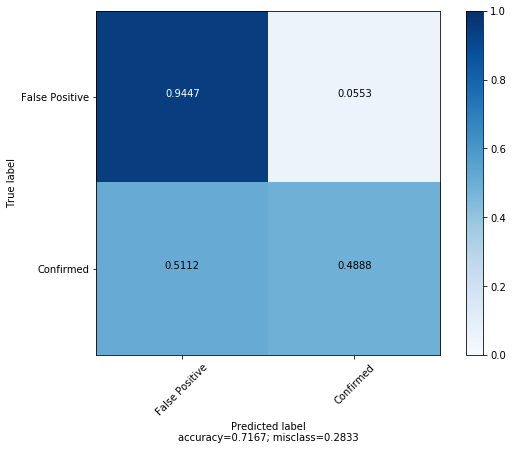

{'Precision raw': array([0.77449047, 0.82619647]),
 'Recall raw': array([0.9446672 , 0.48882265]),
 'F1 raw': array([0.85115607, 0.61423221]),
 'F1 weighted': 0.7682697764500481,
 'F1 macro': 0.7326941395509948,
 'F1 micro': 0.7851929092805006,
 'Confusion Matrix': array([[1178,   69],
        [ 343,  328]])}

In [27]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

## focal loss
> sin lr decay

In [57]:
keras.losses.binary_focal_loss_fixed = keras.losses.mse

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 642us/step - loss: 91.6468 - acc: 0.5679 - val_loss: 20.6104 - val_acc: 0.5288
Epoch 2/200
7810/7810 [==============================] - 2s 236us/step - loss: 20.3817 - acc: 0.6205 - val_loss: 18.4819 - val_acc: 0.6452
Epoch 3/200
7810/7810 [==============================] - 2s 235us/step - loss: 18.8977 - acc: 0.6300 - val_loss: 18.1896 - val_acc: 0.6164
Epoch 4/200
7810/7810 [==============================] - 2s 234us/step - loss: 18.4422 - acc: 0.6355 - val_loss: 17.9426 - val_acc: 0.6740
Epoch 5/200
7810/7810 [==============================] - 2s 237us/step - loss: 18.4037 - acc: 0.6259 - val_loss: 17.9663 - val_acc: 0.6106
Epoch 6/200
7810/7810 [==============================] - 2s 233us/step - loss: 18.3666 - acc: 0.6324 - val_loss: 17.9290 - val_acc: 0.6601
Epoch 7/200
7810/7810 [==============================] - 2s 236us/step - loss: 18.1411 - acc: 0.6273 - val_loss: 17.799

Epoch 35/200
7810/7810 [==============================] - 2s 234us/step - loss: 16.7189 - acc: 0.6853 - val_loss: 16.5956 - val_acc: 0.6774
Epoch 36/200
7810/7810 [==============================] - 2s 231us/step - loss: 16.6893 - acc: 0.6886 - val_loss: 16.6944 - val_acc: 0.6359
Epoch 37/200
7810/7810 [==============================] - 2s 234us/step - loss: 16.6302 - acc: 0.6837 - val_loss: 16.5784 - val_acc: 0.6325
Epoch 38/200
7810/7810 [==============================] - 2s 231us/step - loss: 16.7311 - acc: 0.6845 - val_loss: 16.6289 - val_acc: 0.6371
Epoch 39/200
7810/7810 [==============================] - 2s 232us/step - loss: 16.6638 - acc: 0.6890 - val_loss: 16.3424 - val_acc: 0.6521
Epoch 40/200
7810/7810 [==============================] - 2s 235us/step - loss: 16.5312 - acc: 0.6855 - val_loss: 16.3752 - val_acc: 0.6463
Epoch 41/200
7810/7810 [==============================] - 2s 228us/step - loss: 16.5843 - acc: 0.6907 - val_loss: 16.4585 - val_acc: 0.6440
Epoch 42/200
7810/78

Epoch 69/200
7810/7810 [==============================] - 2s 235us/step - loss: 15.9560 - acc: 0.7119 - val_loss: 15.5878 - val_acc: 0.6866
Epoch 70/200
7810/7810 [==============================] - 2s 234us/step - loss: 15.8178 - acc: 0.7224 - val_loss: 15.6291 - val_acc: 0.6659
Epoch 71/200
7810/7810 [==============================] - 2s 228us/step - loss: 15.8540 - acc: 0.7156 - val_loss: 15.3322 - val_acc: 0.7005
Epoch 72/200
7810/7810 [==============================] - 2s 229us/step - loss: 15.8065 - acc: 0.7168 - val_loss: 15.4405 - val_acc: 0.6797
Epoch 73/200
7810/7810 [==============================] - 2s 231us/step - loss: 15.6245 - acc: 0.7204 - val_loss: 15.6874 - val_acc: 0.6671
Epoch 74/200
7810/7810 [==============================] - 2s 231us/step - loss: 15.8436 - acc: 0.7149 - val_loss: 15.3041 - val_acc: 0.6878
Epoch 75/200
7810/7810 [==============================] - 2s 238us/step - loss: 15.6744 - acc: 0.7175 - val_loss: 15.2277 - val_acc: 0.6889
Epoch 76/200
7810/78

Epoch 103/200
7810/7810 [==============================] - 2s 232us/step - loss: 15.1938 - acc: 0.7396 - val_loss: 15.3070 - val_acc: 0.6763
Epoch 104/200
7810/7810 [==============================] - 2s 227us/step - loss: 15.3917 - acc: 0.7394 - val_loss: 15.2540 - val_acc: 0.6855
Epoch 105/200
7810/7810 [==============================] - 2s 231us/step - loss: 15.3774 - acc: 0.7311 - val_loss: 14.7279 - val_acc: 0.7039
Epoch 106/200
7810/7810 [==============================] - 2s 227us/step - loss: 15.2700 - acc: 0.7289 - val_loss: 14.5996 - val_acc: 0.7051
Epoch 107/200
7810/7810 [==============================] - 2s 234us/step - loss: 15.3631 - acc: 0.7346 - val_loss: 14.9762 - val_acc: 0.6935
Epoch 108/200
7810/7810 [==============================] - 2s 239us/step - loss: 15.3073 - acc: 0.7333 - val_loss: 14.9028 - val_acc: 0.6901
Epoch 109/200
7810/7810 [==============================] - 2s 245us/step - loss: 15.1058 - acc: 0.7341 - val_loss: 14.8383 - val_acc: 0.6982
Epoch 110/200

Epoch 137/200
7810/7810 [==============================] - 2s 247us/step - loss: 14.8898 - acc: 0.7467 - val_loss: 14.5280 - val_acc: 0.7131
Epoch 138/200
7810/7810 [==============================] - 2s 233us/step - loss: 14.7952 - acc: 0.7483 - val_loss: 14.7146 - val_acc: 0.7120
Epoch 139/200
7810/7810 [==============================] - 2s 254us/step - loss: 14.7543 - acc: 0.7406 - val_loss: 14.2628 - val_acc: 0.7166
Epoch 140/200
7810/7810 [==============================] - 2s 238us/step - loss: 14.8470 - acc: 0.7443 - val_loss: 14.9359 - val_acc: 0.6901
Epoch 141/200
7810/7810 [==============================] - 2s 230us/step - loss: 14.8956 - acc: 0.7401 - val_loss: 14.6153 - val_acc: 0.7097
Epoch 142/200
7810/7810 [==============================] - 2s 226us/step - loss: 14.7118 - acc: 0.7464 - val_loss: 14.1503 - val_acc: 0.7258
Epoch 143/200
7810/7810 [==============================] - 2s 226us/step - loss: 14.7826 - acc: 0.7439 - val_loss: 14.2628 - val_acc: 0.7258
Epoch 144/200

Epoch 171/200
7810/7810 [==============================] - 2s 229us/step - loss: 14.5381 - acc: 0.7487 - val_loss: 14.3195 - val_acc: 0.7189
Epoch 172/200
7810/7810 [==============================] - 2s 228us/step - loss: 14.6145 - acc: 0.7481 - val_loss: 14.1274 - val_acc: 0.7224
Epoch 173/200
7810/7810 [==============================] - 2s 229us/step - loss: 14.5451 - acc: 0.7517 - val_loss: 14.3801 - val_acc: 0.7062
Epoch 174/200
7810/7810 [==============================] - 2s 229us/step - loss: 14.3235 - acc: 0.7531 - val_loss: 14.1344 - val_acc: 0.7247
Epoch 175/200
7810/7810 [==============================] - 2s 230us/step - loss: 14.5504 - acc: 0.7528 - val_loss: 14.6919 - val_acc: 0.6878
Epoch 176/200
7810/7810 [==============================] - 2s 230us/step - loss: 14.4384 - acc: 0.7565 - val_loss: 13.8298 - val_acc: 0.7224
Epoch 177/200
7810/7810 [==============================] - 2s 240us/step - loss: 14.3822 - acc: 0.7597 - val_loss: 13.9019 - val_acc: 0.7304
Epoch 178/200

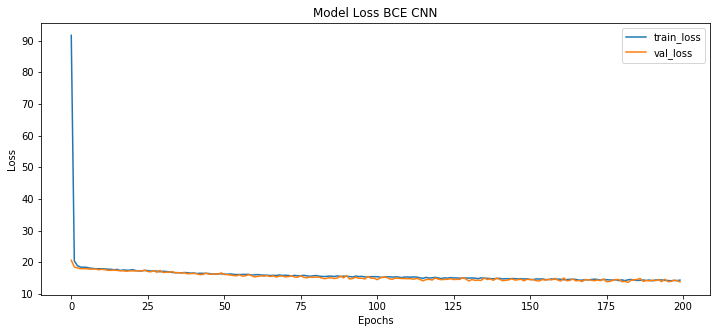

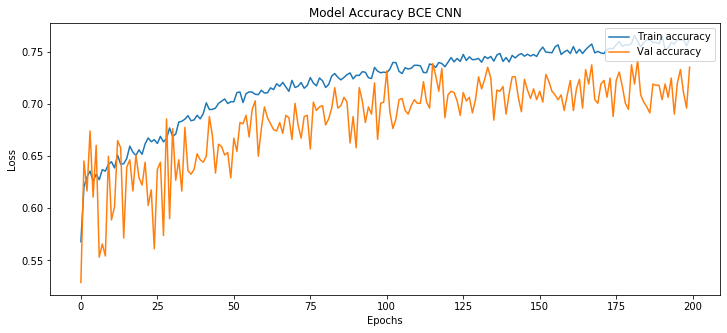

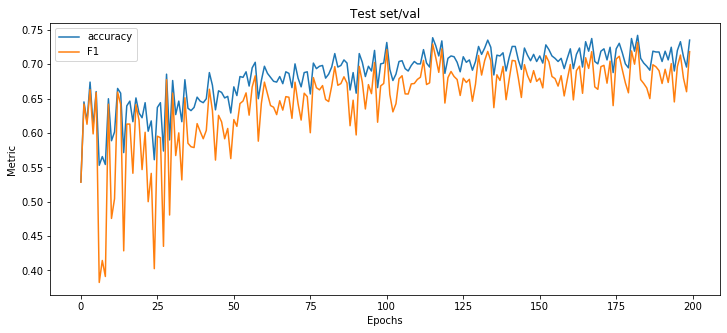

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.797737,0.904571,0.847802,0.780463,0.75156,0.788843
Confirmed,0.763889,0.573770,0.655319,0.780463,0.75156,0.788843


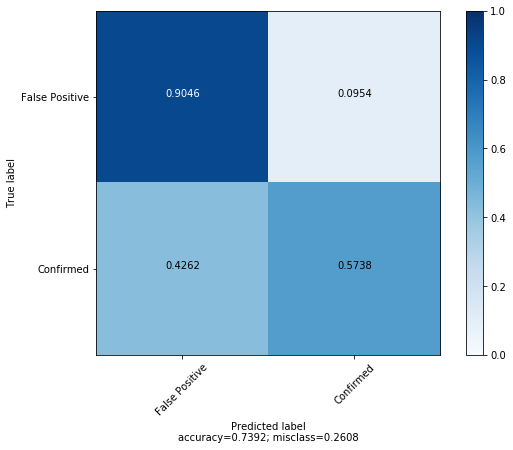

{'Precision raw': array([0.79773692, 0.76388889]),
 'Recall raw': array([0.90457097, 0.57377049]),
 'F1 raw': array([0.84780158, 0.65531915]),
 'F1 weighted': 0.780462834798546,
 'F1 macro': 0.7515603636450863,
 'F1 micro': 0.7888425443169969,
 'Confusion Matrix': array([[1128,  119],
        [ 286,  385]])}

In [58]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [15]:
from keras.models import Model
from keras.layers import *

def add_CNN(it, filters, kernel_s, BN = False, **args):
    f1 = Conv2D(filters, kernel_s, activation='relu', padding='valid', **args)(it)
    if BN:
        f1 = BatchNormalization()(f1)
    return f1
                                                           
def conv_bloq(it, filters, kernel_s, pool, drop=0, BN=False,double=False, **args):
    ## **args could be any other conv1d parameter
    f1 = add_CNN(it, filters, kernel_s, BN = BN, **args)
    if double:
        f1 = add_CNN(f1, filters, kernel_s, BN = BN, **args)
        
    if pool!= 0:
        f1 = MaxPool2D(pool_size=pool, strides=pool, padding='valid')(f1)
        #f1 = AveragePooling1D(pool_size=pool, strides=pool, padding='valid')(f1)
    if drop != 0:
        f1 = Dropout(drop)(f1)
    return f1

def encoder_model(input_dim, L=1, filters=8, kernel_s =10, pool=5, BN=False, drop=0,
                        flatten =True,time=False,double=False, **args): 
    #parametros estructurales-- args es cuqluier parameter de conv1d
    it = Input(shape=input_dim)  #fixed length..
    f1 = it
    start_f = filters
    for l in range(L):
        f1 = conv_bloq(f1, filters, kernel_s, pool, drop=drop,BN=BN,double=double, **args) 
        
        filters = int(filters*2)
        filters = min(512, filters)
        if time:
            filters = min(128, filters)
            
    if flatten:
        f1 = Flatten()(f1)
    else:
        #f1 = GlobalMaxPool2D()(f1)
        f1 = GlobalAveragePooling2D()(f1)
    return Model(inputs=it, outputs=f1)

In [29]:
encoder = encoder_model(x_train.shape[1:], L=3, filters=64, kernel_s=(3,3), pool=2,flatten=False, double=False)
encoder.summary()

it = Input(shape=x_train.shape[1:])
f1 = Dense(128, activation='relu')(encoder(it))
f1 = Dropout(0.5)(f1)
out = Dense(1, activation='sigmoid')(f1)

model = Model(it, out)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 64)        1216      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 2, 256)         0         
__________

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 7s 909us/step - loss: 0.6101 - acc: 0.6246 - val_loss: 0.6072 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 5s 627us/step - loss: 0.5760 - acc: 0.6318 - val_loss: 0.6256 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 5s 633us/step - loss: 0.5656 - acc: 0.6371 - val_loss: 0.6030 - val_acc: 0.6671
Epoch 4/200
7810/7810 [==============================] - 5s 634us/step - loss: 0.6129 - acc: 0.6309 - val_loss: 0.6096 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 5s 621us/step - loss: 0.5636 - acc: 0.6279 - val_loss: 0.6843 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 5s 634us/step - loss: 0.5554 - acc: 0.6312 - val_loss: 0.5843 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 5s 641us/step - loss: 0.5453 - acc: 0.6375 - val_loss: 0.5740 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 5s 638us/step - loss: 0.4289 - acc: 0.7672 - val_loss: 0.4448 - val_acc: 0.7650
Epoch 36/200
7810/7810 [==============================] - 5s 631us/step - loss: 0.4330 - acc: 0.7658 - val_loss: 0.5122 - val_acc: 0.7097
Epoch 37/200
7810/7810 [==============================] - 5s 629us/step - loss: 0.4205 - acc: 0.7752 - val_loss: 0.4965 - val_acc: 0.6878
Epoch 38/200
7810/7810 [==============================] - 5s 649us/step - loss: 0.4704 - acc: 0.7374 - val_loss: 0.5762 - val_acc: 0.6751
Epoch 39/200
7810/7810 [==============================] - 5s 639us/step - loss: 0.4540 - acc: 0.7530 - val_loss: 0.5601 - val_acc: 0.6463
Epoch 40/200
7810/7810 [==============================] - 5s 637us/step - loss: 0.4312 - acc: 0.7712 - val_loss: 0.4947 - val_acc: 0.7200
Epoch 41/200
7810/7810 [==============================] - 5s 637us/step - loss: 0.4442 - acc: 0.7606 - val_loss: 0.5003 - val_acc: 0.7189
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 5s 639us/step - loss: 0.3131 - acc: 0.8420 - val_loss: 0.4353 - val_acc: 0.7615
Epoch 104/200
7810/7810 [==============================] - 5s 629us/step - loss: 0.3089 - acc: 0.8465 - val_loss: 0.4773 - val_acc: 0.7454
Epoch 105/200
7810/7810 [==============================] - 5s 626us/step - loss: 0.3227 - acc: 0.8353 - val_loss: 0.4373 - val_acc: 0.7661
Epoch 106/200
7810/7810 [==============================] - 5s 653us/step - loss: 0.3004 - acc: 0.8489 - val_loss: 0.4101 - val_acc: 0.7846
Epoch 107/200
7810/7810 [==============================] - 5s 654us/step - loss: 0.2975 - acc: 0.8522 - val_loss: 0.6125 - val_acc: 0.7200
Epoch 108/200
7810/7810 [==============================] - 5s 629us/step - loss: 0.3253 - acc: 0.8346 - val_loss: 0.4746 - val_acc: 0.7558
Epoch 109/200
7810/7810 [==============================] - 5s 623us/step - loss: 0.3114 - acc: 0.8421 - val_loss: 0.4998 - val_acc: 0.7362
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 5s 636us/step - loss: 0.2450 - acc: 0.8827 - val_loss: 0.4935 - val_acc: 0.7638
Epoch 138/200
7810/7810 [==============================] - 5s 629us/step - loss: 0.2446 - acc: 0.8832 - val_loss: 0.6835 - val_acc: 0.7212
Epoch 139/200
7810/7810 [==============================] - 5s 627us/step - loss: 0.2532 - acc: 0.8807 - val_loss: 0.4402 - val_acc: 0.7753
Epoch 140/200
7810/7810 [==============================] - 5s 625us/step - loss: 0.2273 - acc: 0.8917 - val_loss: 0.4886 - val_acc: 0.7615
Epoch 141/200
7810/7810 [==============================] - 5s 622us/step - loss: 0.2469 - acc: 0.8814 - val_loss: 0.9049 - val_acc: 0.6889
Epoch 142/200
7810/7810 [==============================] - 5s 624us/step - loss: 0.3559 - acc: 0.8255 - val_loss: 0.4630 - val_acc: 0.7650
Epoch 143/200
7810/7810 [==============================] - 5s 627us/step - loss: 0.2603 - acc: 0.8698 - val_loss: 0.6450 - val_acc: 0.7270
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 5s 616us/step - loss: 0.1719 - acc: 0.9230 - val_loss: 0.6373 - val_acc: 0.7546
Epoch 172/200
7810/7810 [==============================] - 5s 626us/step - loss: 0.1498 - acc: 0.9335 - val_loss: 0.6297 - val_acc: 0.7707
Epoch 173/200
7810/7810 [==============================] - 5s 625us/step - loss: 0.1445 - acc: 0.9378 - val_loss: 0.5944 - val_acc: 0.7788
Epoch 174/200
7810/7810 [==============================] - 5s 624us/step - loss: 0.1394 - acc: 0.9393 - val_loss: 0.7039 - val_acc: 0.7615
Epoch 175/200
7810/7810 [==============================] - 5s 623us/step - loss: 0.2750 - acc: 0.8749 - val_loss: 0.6058 - val_acc: 0.7730
Epoch 176/200
7810/7810 [==============================] - 5s 624us/step - loss: 0.2284 - acc: 0.8971 - val_loss: 0.5516 - val_acc: 0.7742
Epoch 177/200
7810/7810 [==============================] - 5s 636us/step - loss: 0.1562 - acc: 0.9312 - val_loss: 0.5794 - val_acc: 0.7707
Epoch 178/200
7810/7810 [================

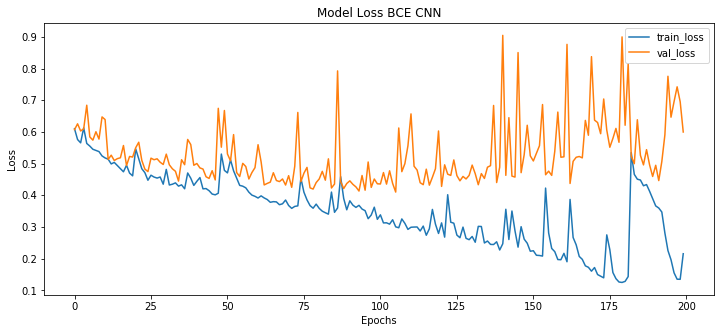

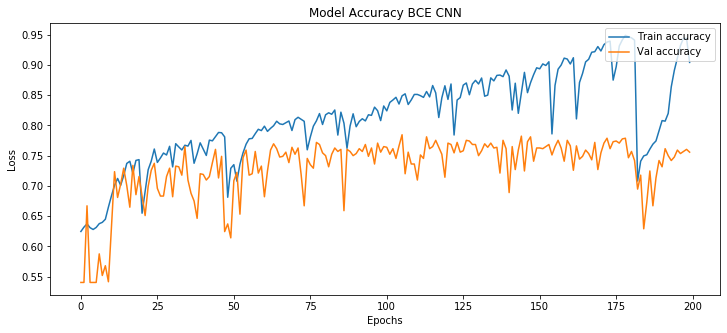

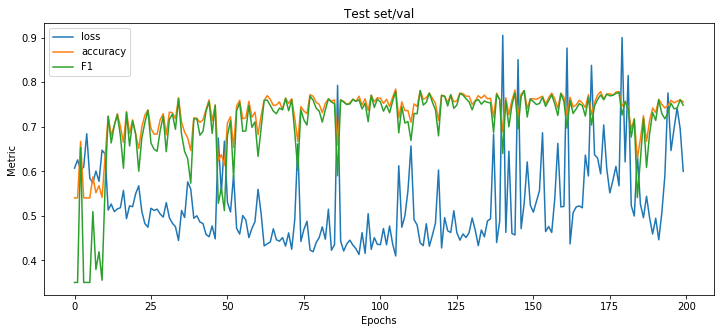

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.829992,0.829992,0.829992,0.778936,0.757023,0.778936
Confirmed,0.684054,0.684054,0.684054,0.778936,0.757023,0.778936


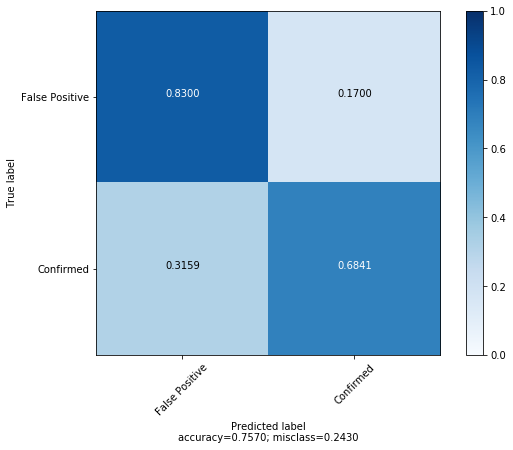

{'Precision raw': array([0.82999198, 0.68405365]),
 'Recall raw': array([0.82999198, 0.68405365]),
 'F1 raw': array([0.82999198, 0.68405365]),
 'F1 weighted': 0.7789363920750783,
 'F1 macro': 0.7570228160102875,
 'F1 micro': 0.7789363920750783,
 'Confusion Matrix': array([[1035,  212],
        [ 212,  459]])}

In [30]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...

predichos = (model.predict(x_val)>=0.5)*1
calculate_metrics(y_val, predichos,'...')

## Towers

In [57]:
n = 5

x_train1 = channel_1[:,:,:,:n][mask_train]
x_train2 = channel_2[:,:,:,:n][mask_train]
x_train_lc = np.concatenate([x_train1,x_train2]) #concat
x_train_t = channel_3[mask_train]

x_val_lc = channel_1[:,:,:,:n][mask_test]
x_val_t = np.expand_dims(channel_3[mask_test], axis=-1)

x_train_t = np.expand_dims(np.tile(x_train_t, (2,1,1)), axis=-1)
if x_train_lc.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train_lc.shape, y_train.shape)
print ("Objetos de validación:",x_val_lc.shape,y_val.shape)

Objetos de entrenamiento: (8678, 32, 32, 3) (8678,)
Objetos de validación: (1918, 32, 32, 3) (1918,)


In [65]:
x_train_lc = np.log(x_train_lc)
x_val_lc = np.log(x_val_lc)

#x_train_t = np.log(x_train_t)
#x_val_t = np.log(x_val_t)

In [66]:
encoder = encoder_model(x_train_lc.shape[1:], L=2, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=False)

encoder.summary()

encoder_t = encoder_model(x_train_t.shape[1:], L=2, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)              0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [59]:
encoder = encoder_model(x_train_lc.shape[1:], L=3, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=False)

encoder.summary()

encoder_t = encoder_model(x_train_t.shape[1:], L=3, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 2, 128)         0         
__________

In [62]:
encoder = encoder_model(x_train_lc.shape[1:], L=3, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=False,drop=0.25)

encoder.summary()

encoder_t = encoder_model(x_train_t.shape[1:], L=3, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=True,drop=0.25)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 6, 64)          0         
__________

In [67]:
## combine two "tower"
it_time = Input(shape=x_train_t.shape[1:])
it_lc = Input(shape=x_train_lc.shape[1:])
encoder_time = encoder_t(it_time)
encoder_lc = encoder(it_lc)
concat_encoder = keras.layers.Concatenate()([encoder_time,encoder_lc])

f1 = Dropout(0.5)(concat_encoder) #or not...
#f1 = concat_encoder

#similar FF layer of baseline
f1 = Dense(128, activation='relu')(f1)
f1 = Dropout(0.5)(f1)
out = Dense(1, activation='sigmoid')(f1)

CNN_all = Model([it_time,it_lc], out)
CNN_all.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_18 (Model)                (None, 2304)         18816       input_25[0][0]                   
__________________________________________________________________________________________________
model_17 (Model)                (None, 2304)         19392       input_26[0][0]                   
__________________________________________________________________________________________________
concatenat

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 649us/step - loss: 0.5847 - acc: 0.6256 - val_loss: 0.5912 - val_acc: 0.5426
Epoch 2/200
7810/7810 [==============================] - 4s 493us/step - loss: 0.5520 - acc: 0.6380 - val_loss: 0.5885 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 3s 448us/step - loss: 0.5425 - acc: 0.6458 - val_loss: 0.5974 - val_acc: 0.5461
Epoch 4/200
7810/7810 [==============================] - 4s 452us/step - loss: 0.5410 - acc: 0.6452 - val_loss: 0.5604 - val_acc: 0.6786
Epoch 5/200
7810/7810 [==============================] - 4s 460us/step - loss: 0.5325 - acc: 0.6528 - val_loss: 0.5528 - val_acc: 0.6694
Epoch 6/200
7810/7810 [==============================] - 4s 461us/step - loss: 0.5285 - acc: 0.6609 - val_loss: 0.5447 - val_acc: 0.7062
Epoch 7/200
7810/7810 [==============================] - 4s 455us/step - loss: 0.5204 - acc: 0.6716 - val_loss: 0.5719 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 4s 451us/step - loss: 0.4579 - acc: 0.7361 - val_loss: 0.4918 - val_acc: 0.7120
Epoch 36/200
7810/7810 [==============================] - 3s 445us/step - loss: 0.4687 - acc: 0.7225 - val_loss: 0.4984 - val_acc: 0.6924
Epoch 37/200
7810/7810 [==============================] - 4s 449us/step - loss: 0.4572 - acc: 0.7327 - val_loss: 0.5328 - val_acc: 0.6498
Epoch 38/200
7810/7810 [==============================] - 3s 444us/step - loss: 0.4517 - acc: 0.7426 - val_loss: 0.4999 - val_acc: 0.6935
Epoch 39/200
7810/7810 [==============================] - 4s 449us/step - loss: 0.4570 - acc: 0.7338 - val_loss: 0.4839 - val_acc: 0.7200
Epoch 40/200
7810/7810 [==============================] - 4s 453us/step - loss: 0.4562 - acc: 0.7356 - val_loss: 0.4860 - val_acc: 0.7131
Epoch 41/200
7810/7810 [==============================] - 4s 453us/step - loss: 0.4522 - acc: 0.7376 - val_loss: 0.4775 - val_acc: 0.7247
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 4s 450us/step - loss: 0.3441 - acc: 0.8334 - val_loss: 0.5150 - val_acc: 0.6993
Epoch 104/200
7810/7810 [==============================] - 3s 446us/step - loss: 0.3362 - acc: 0.8341 - val_loss: 0.5225 - val_acc: 0.6970
Epoch 105/200
7810/7810 [==============================] - 3s 442us/step - loss: 0.3688 - acc: 0.8124 - val_loss: 0.4987 - val_acc: 0.7143
Epoch 106/200
7810/7810 [==============================] - 4s 473us/step - loss: 0.3399 - acc: 0.8339 - val_loss: 0.4977 - val_acc: 0.7270
Epoch 107/200
7810/7810 [==============================] - 4s 469us/step - loss: 0.3434 - acc: 0.8318 - val_loss: 0.5004 - val_acc: 0.7177
Epoch 108/200
7810/7810 [==============================] - 3s 447us/step - loss: 0.3547 - acc: 0.8219 - val_loss: 0.4970 - val_acc: 0.7143
Epoch 109/200
7810/7810 [==============================] - 3s 445us/step - loss: 0.3445 - acc: 0.8289 - val_loss: 0.4908 - val_acc: 0.7247
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 4s 470us/step - loss: 0.3000 - acc: 0.8586 - val_loss: 0.5330 - val_acc: 0.7143
Epoch 138/200
7810/7810 [==============================] - 4s 451us/step - loss: 0.3020 - acc: 0.8584 - val_loss: 0.5858 - val_acc: 0.7074
Epoch 139/200
7810/7810 [==============================] - 4s 460us/step - loss: 0.2797 - acc: 0.8706 - val_loss: 0.5262 - val_acc: 0.7339
Epoch 140/200
7810/7810 [==============================] - 3s 448us/step - loss: 0.2522 - acc: 0.8860 - val_loss: 0.5570 - val_acc: 0.7143
Epoch 141/200
7810/7810 [==============================] - 4s 465us/step - loss: 0.2480 - acc: 0.8917 - val_loss: 0.5834 - val_acc: 0.7281
Epoch 142/200
7810/7810 [==============================] - 4s 461us/step - loss: 0.2568 - acc: 0.8854 - val_loss: 0.5720 - val_acc: 0.7200
Epoch 143/200
7810/7810 [==============================] - 4s 460us/step - loss: 0.2592 - acc: 0.8826 - val_loss: 0.5400 - val_acc: 0.7166
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 3s 447us/step - loss: 0.2168 - acc: 0.9090 - val_loss: 0.6012 - val_acc: 0.7316
Epoch 172/200
7810/7810 [==============================] - 3s 447us/step - loss: 0.2824 - acc: 0.8693 - val_loss: 0.5860 - val_acc: 0.7177
Epoch 173/200
7810/7810 [==============================] - 4s 471us/step - loss: 0.2239 - acc: 0.9027 - val_loss: 0.6296 - val_acc: 0.7212
Epoch 174/200
7810/7810 [==============================] - 3s 444us/step - loss: 0.2737 - acc: 0.8722 - val_loss: 0.5386 - val_acc: 0.7327
Epoch 175/200
7810/7810 [==============================] - 4s 449us/step - loss: 0.2907 - acc: 0.8672 - val_loss: 0.5854 - val_acc: 0.7316
Epoch 176/200
7810/7810 [==============================] - 3s 448us/step - loss: 0.2221 - acc: 0.9068 - val_loss: 0.6159 - val_acc: 0.7108
Epoch 177/200
7810/7810 [==============================] - 4s 467us/step - loss: 0.2041 - acc: 0.9141 - val_loss: 0.5872 - val_acc: 0.7304
Epoch 178/200
7810/7810 [================

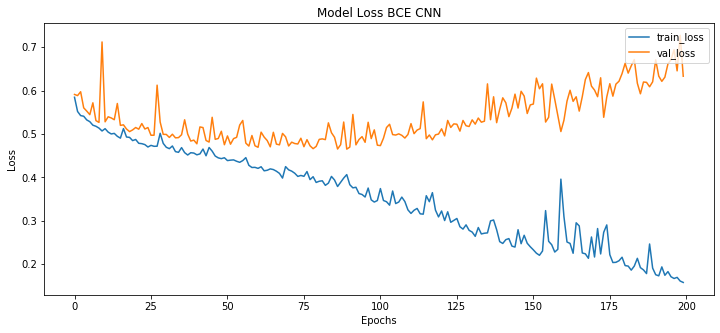

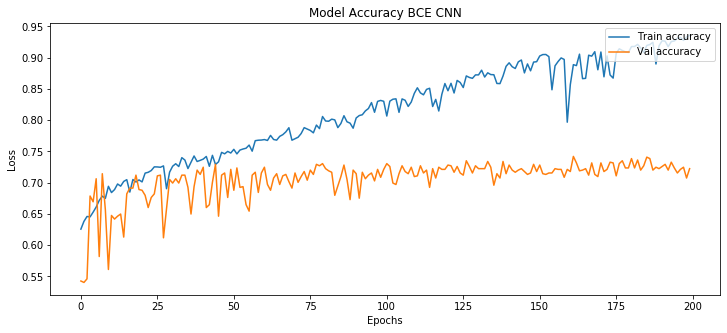

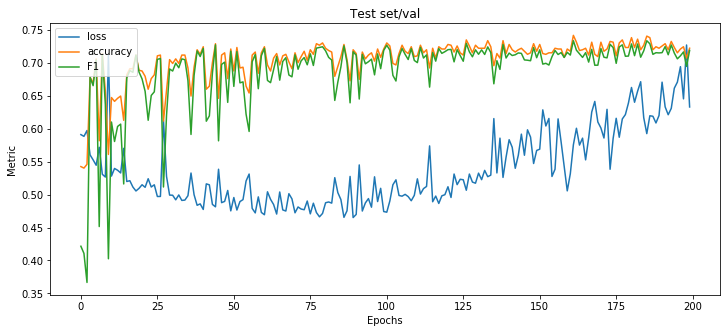

IndexError: index 1918 is out of bounds for axis 0 with size 1918

In [53]:
train_model(CNN_all, [x_train_t,x_train_lc], y_train, [x_val_t,x_val_lc], y_val, e=200, BS=128)  #save model

CNN_all = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...

predichos = (CNN_all.predict([x_val_t,x_val_lc])>=0.5)*1
calculate_metrics(y_val, predichos,'...')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.835757,0.78348,0.808775,0.761851,0.741711,0.759124
Confirmed,0.639519,0.71386,0.674648,0.761851,0.741711,0.759124


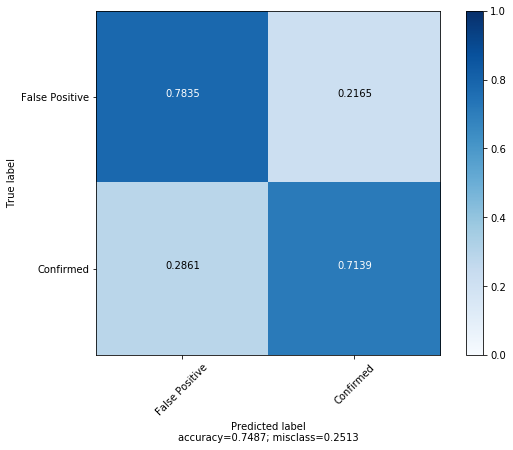

{'Precision raw': array([0.83575706, 0.63951936]),
 'Recall raw': array([0.78348035, 0.71385991]),
 'F1 raw': array([0.80877483, 0.67464789]),
 'F1 weighted': 0.7618513821362943,
 'F1 macro': 0.7417113608805148,
 'F1 micro': 0.7591240875912408,
 'Confusion Matrix': array([[977, 270],
        [192, 479]])}

In [58]:

predichos = (CNN_all.predict([x_val_t,x_val_lc])>=0.5)*1
calculate_metrics(y_val, predichos,'...')

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 7s 875us/step - loss: 0.5828 - acc: 0.6373 - val_loss: 0.5877 - val_acc: 0.5380
Epoch 2/200
7810/7810 [==============================] - 4s 529us/step - loss: 0.5512 - acc: 0.6328 - val_loss: 0.5983 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 4s 559us/step - loss: 0.5433 - acc: 0.6357 - val_loss: 0.5696 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 4s 529us/step - loss: 0.5371 - acc: 0.6402 - val_loss: 0.5641 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 4s 527us/step - loss: 0.5309 - acc: 0.6402 - val_loss: 0.5559 - val_acc: 0.6394
Epoch 6/200
7810/7810 [==============================] - 4s 519us/step - loss: 0.5293 - acc: 0.6466 - val_loss: 0.5728 - val_acc: 0.5495
Epoch 7/200
7810/7810 [==============================] - 4s 513us/step - loss: 0.5383 - acc: 0.6470 - val_loss: 0.5642 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 4s 509us/step - loss: 0.4782 - acc: 0.7046 - val_loss: 0.5129 - val_acc: 0.7028
Epoch 36/200
7810/7810 [==============================] - 4s 514us/step - loss: 0.4752 - acc: 0.7077 - val_loss: 0.5131 - val_acc: 0.6935
Epoch 37/200
7810/7810 [==============================] - 4s 514us/step - loss: 0.4869 - acc: 0.6936 - val_loss: 0.5110 - val_acc: 0.6797
Epoch 38/200
7810/7810 [==============================] - 4s 510us/step - loss: 0.4730 - acc: 0.7050 - val_loss: 0.5134 - val_acc: 0.6774
Epoch 39/200
7810/7810 [==============================] - 4s 518us/step - loss: 0.4695 - acc: 0.7141 - val_loss: 0.4939 - val_acc: 0.7005
Epoch 40/200
7810/7810 [==============================] - 4s 520us/step - loss: 0.4690 - acc: 0.7119 - val_loss: 0.4922 - val_acc: 0.7074
Epoch 41/200
7810/7810 [==============================] - 4s 517us/step - loss: 0.4681 - acc: 0.7163 - val_loss: 0.4939 - val_acc: 0.7005
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 4s 510us/step - loss: 0.4258 - acc: 0.7588 - val_loss: 0.4719 - val_acc: 0.7131
Epoch 104/200
7810/7810 [==============================] - 4s 513us/step - loss: 0.4315 - acc: 0.7581 - val_loss: 0.4765 - val_acc: 0.7131
Epoch 105/200
7810/7810 [==============================] - 4s 510us/step - loss: 0.4286 - acc: 0.7515 - val_loss: 0.5011 - val_acc: 0.6705
Epoch 106/200
7810/7810 [==============================] - 4s 514us/step - loss: 0.4323 - acc: 0.7519 - val_loss: 0.5169 - val_acc: 0.6866
Epoch 107/200
7810/7810 [==============================] - 4s 511us/step - loss: 0.4305 - acc: 0.7515 - val_loss: 0.4839 - val_acc: 0.6889
Epoch 108/200
7810/7810 [==============================] - 4s 509us/step - loss: 0.4216 - acc: 0.7636 - val_loss: 0.4796 - val_acc: 0.7131
Epoch 109/200
7810/7810 [==============================] - 4s 547us/step - loss: 0.4224 - acc: 0.7557 - val_loss: 0.4766 - val_acc: 0.7074
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 4s 518us/step - loss: 0.3944 - acc: 0.7896 - val_loss: 0.4671 - val_acc: 0.7189
Epoch 138/200
7810/7810 [==============================] - 4s 516us/step - loss: 0.4072 - acc: 0.7771 - val_loss: 0.4640 - val_acc: 0.7247
Epoch 139/200
7810/7810 [==============================] - 4s 516us/step - loss: 0.4040 - acc: 0.7840 - val_loss: 0.4577 - val_acc: 0.7281
Epoch 140/200
7810/7810 [==============================] - 4s 510us/step - loss: 0.3948 - acc: 0.7877 - val_loss: 0.4587 - val_acc: 0.7385
Epoch 141/200
7810/7810 [==============================] - 4s 519us/step - loss: 0.4104 - acc: 0.7721 - val_loss: 0.4553 - val_acc: 0.7270
Epoch 142/200
7810/7810 [==============================] - 4s 517us/step - loss: 0.3958 - acc: 0.7841 - val_loss: 0.4544 - val_acc: 0.7373
Epoch 143/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.4119 - acc: 0.7686 - val_loss: 0.4576 - val_acc: 0.7431
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 4s 516us/step - loss: 0.3630 - acc: 0.8099 - val_loss: 0.4753 - val_acc: 0.7385
Epoch 172/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.3650 - acc: 0.8119 - val_loss: 0.4645 - val_acc: 0.7339
Epoch 173/200
7810/7810 [==============================] - 4s 545us/step - loss: 0.4306 - acc: 0.7588 - val_loss: 0.4547 - val_acc: 0.7258
Epoch 174/200
7810/7810 [==============================] - 4s 514us/step - loss: 0.3917 - acc: 0.7921 - val_loss: 0.4724 - val_acc: 0.7212
Epoch 175/200
7810/7810 [==============================] - 4s 514us/step - loss: 0.3872 - acc: 0.7937 - val_loss: 0.4569 - val_acc: 0.7362
Epoch 176/200
7810/7810 [==============================] - 4s 519us/step - loss: 0.3768 - acc: 0.8015 - val_loss: 0.4689 - val_acc: 0.7304
Epoch 177/200
7810/7810 [==============================] - 4s 515us/step - loss: 0.3634 - acc: 0.8101 - val_loss: 0.4786 - val_acc: 0.7224
Epoch 178/200
7810/7810 [================

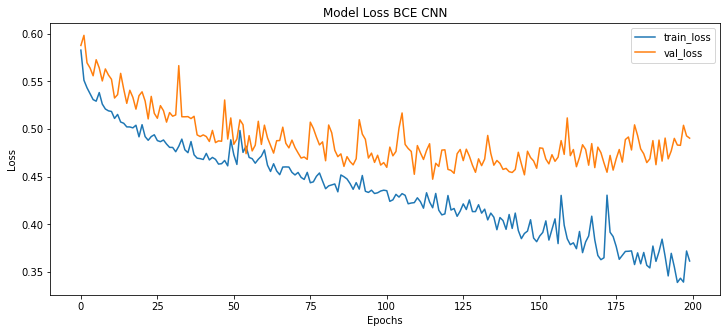

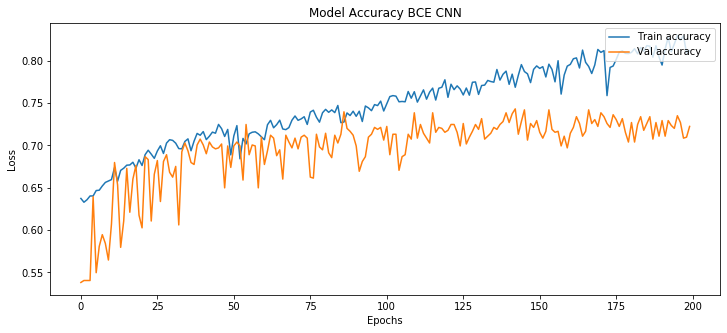

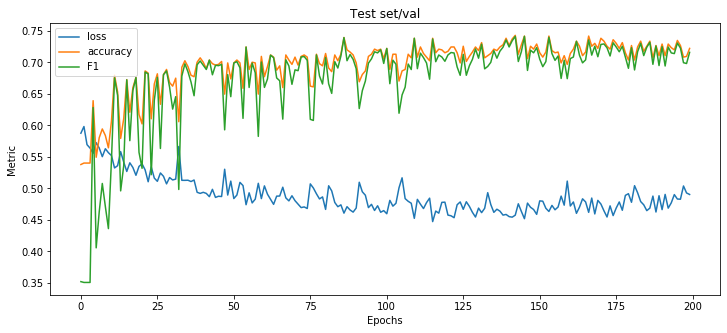

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.837398,0.743384,0.787596,0.743873,0.725107,0.739312
Confirmed,0.605425,0.731744,0.662618,0.743873,0.725107,0.739312


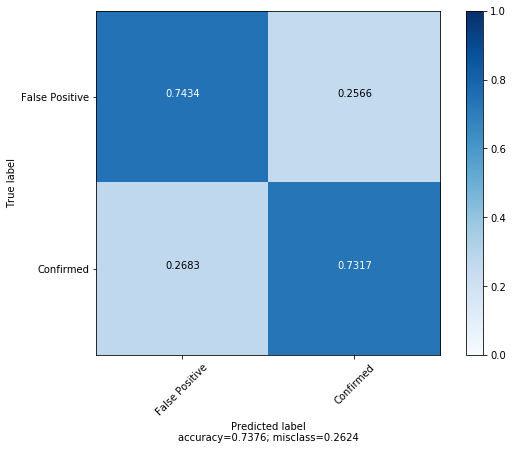

{'Precision raw': array([0.83739837, 0.6054254 ]),
 'Recall raw': array([0.74338412, 0.73174367]),
 'F1 raw': array([0.78759558, 0.66261808]),
 'F1 weighted': 0.7438730056737316,
 'F1 macro': 0.7251068328294104,
 'F1 micro': 0.7393117831074035,
 'Confusion Matrix': array([[927, 320],
        [180, 491]])}

In [64]:
### 3 capas con drop en convs

train_model(CNN_all, [x_train_t,x_train_lc], y_train, [x_val_t,x_val_lc], y_val, e=200, BS=128)  #save model

CNN_all = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...

predichos = (CNN_all.predict([x_val_t,x_val_lc])>=0.5)*1
calculate_metrics(y_val, predichos,'...')

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 7s 867us/step - loss: 0.6053 - acc: 0.6248 - val_loss: 0.5783 - val_acc: 0.5956
Epoch 2/200
7810/7810 [==============================] - 4s 454us/step - loss: 0.5476 - acc: 0.6289 - val_loss: 0.6628 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 4s 451us/step - loss: 0.5457 - acc: 0.6350 - val_loss: 0.5701 - val_acc: 0.5599
Epoch 4/200
7810/7810 [==============================] - 4s 467us/step - loss: 0.5380 - acc: 0.6401 - val_loss: 0.5542 - val_acc: 0.6843
Epoch 5/200
7810/7810 [==============================] - 4s 484us/step - loss: 0.5383 - acc: 0.6419 - val_loss: 0.5683 - val_acc: 0.5899
Epoch 6/200
7810/7810 [==============================] - 4s 449us/step - loss: 0.5333 - acc: 0.6506 - val_loss: 0.5587 - val_acc: 0.6636
Epoch 7/200
7810/7810 [==============================] - 4s 451us/step - loss: 0.5332 - acc: 0.6507 - val_loss: 0.5601 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 4s 450us/step - loss: 0.4867 - acc: 0.7054 - val_loss: 0.5232 - val_acc: 0.6567
Epoch 36/200
7810/7810 [==============================] - 3s 447us/step - loss: 0.4960 - acc: 0.6980 - val_loss: 0.5050 - val_acc: 0.7039
Epoch 37/200
7810/7810 [==============================] - 4s 473us/step - loss: 0.4807 - acc: 0.7101 - val_loss: 0.5065 - val_acc: 0.6993
Epoch 38/200
7810/7810 [==============================] - 4s 454us/step - loss: 0.4920 - acc: 0.6985 - val_loss: 0.5073 - val_acc: 0.6809
Epoch 39/200
7810/7810 [==============================] - 4s 453us/step - loss: 0.4781 - acc: 0.7169 - val_loss: 0.5068 - val_acc: 0.6797
Epoch 40/200
7810/7810 [==============================] - 3s 447us/step - loss: 0.4780 - acc: 0.7142 - val_loss: 0.5129 - val_acc: 0.6843
Epoch 41/200
7810/7810 [==============================] - 3s 448us/step - loss: 0.4749 - acc: 0.7214 - val_loss: 0.5030 - val_acc: 0.6786
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 3s 447us/step - loss: 0.4138 - acc: 0.7749 - val_loss: 0.4805 - val_acc: 0.7108
Epoch 104/200
7810/7810 [==============================] - 4s 450us/step - loss: 0.4082 - acc: 0.7835 - val_loss: 0.4840 - val_acc: 0.7051
Epoch 105/200
7810/7810 [==============================] - 4s 449us/step - loss: 0.4093 - acc: 0.7761 - val_loss: 0.4714 - val_acc: 0.7131
Epoch 106/200
7810/7810 [==============================] - 4s 477us/step - loss: 0.4284 - acc: 0.7617 - val_loss: 0.4686 - val_acc: 0.7131
Epoch 107/200
7810/7810 [==============================] - 4s 460us/step - loss: 0.4155 - acc: 0.7695 - val_loss: 0.4681 - val_acc: 0.7120
Epoch 108/200
7810/7810 [==============================] - 4s 465us/step - loss: 0.3969 - acc: 0.7883 - val_loss: 0.4945 - val_acc: 0.6717
Epoch 109/200
7810/7810 [==============================] - 4s 451us/step - loss: 0.4952 - acc: 0.7014 - val_loss: 0.5429 - val_acc: 0.6221
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 4s 450us/step - loss: 0.3550 - acc: 0.8207 - val_loss: 0.4630 - val_acc: 0.7304
Epoch 138/200
7810/7810 [==============================] - 3s 448us/step - loss: 0.3441 - acc: 0.8282 - val_loss: 0.4771 - val_acc: 0.6982
Epoch 139/200
7810/7810 [==============================] - 4s 449us/step - loss: 0.4543 - acc: 0.7431 - val_loss: 0.4887 - val_acc: 0.6797
Epoch 140/200
7810/7810 [==============================] - 4s 450us/step - loss: 0.3885 - acc: 0.8014 - val_loss: 0.4628 - val_acc: 0.7074
Epoch 141/200
7810/7810 [==============================] - 3s 446us/step - loss: 0.3909 - acc: 0.7999 - val_loss: 0.4648 - val_acc: 0.7062
Epoch 142/200
7810/7810 [==============================] - 3s 448us/step - loss: 0.4252 - acc: 0.7703 - val_loss: 0.4716 - val_acc: 0.6959
Epoch 143/200
7810/7810 [==============================] - 3s 446us/step - loss: 0.3933 - acc: 0.7933 - val_loss: 0.4645 - val_acc: 0.7051
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 4s 478us/step - loss: 0.3418 - acc: 0.8296 - val_loss: 0.4745 - val_acc: 0.7200
Epoch 172/200
7810/7810 [==============================] - 4s 459us/step - loss: 0.3480 - acc: 0.8262 - val_loss: 0.4785 - val_acc: 0.7247
Epoch 173/200
7810/7810 [==============================] - 4s 454us/step - loss: 0.3136 - acc: 0.8520 - val_loss: 0.4917 - val_acc: 0.6924
Epoch 174/200
7810/7810 [==============================] - 3s 447us/step - loss: 0.3299 - acc: 0.8402 - val_loss: 0.4668 - val_acc: 0.7200
Epoch 175/200
7810/7810 [==============================] - 4s 453us/step - loss: 0.3105 - acc: 0.8471 - val_loss: 0.4673 - val_acc: 0.7189
Epoch 176/200
7810/7810 [==============================] - 4s 450us/step - loss: 0.2971 - acc: 0.8597 - val_loss: 0.4734 - val_acc: 0.7166
Epoch 177/200
7810/7810 [==============================] - 4s 460us/step - loss: 0.2937 - acc: 0.8635 - val_loss: 0.4807 - val_acc: 0.7212
Epoch 178/200
7810/7810 [================

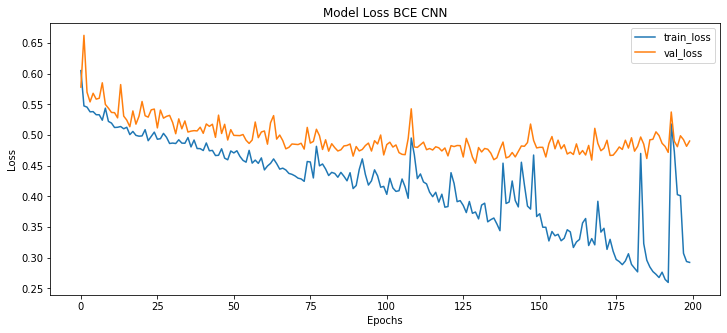

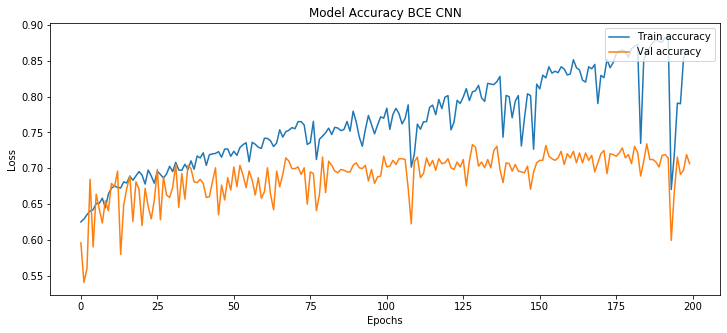

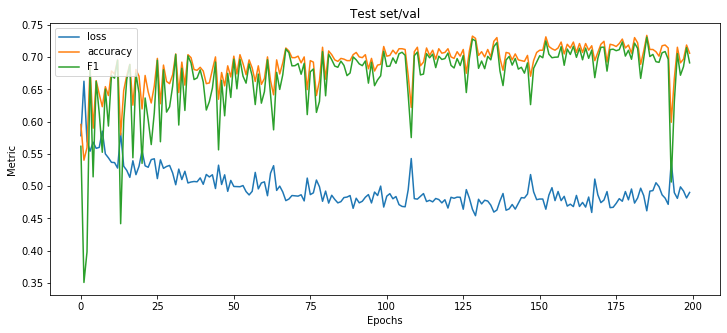

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.812955,0.805132,0.809025,0.753365,0.729476,0.752868
Confirmed,0.644217,0.655738,0.649926,0.753365,0.729476,0.752868


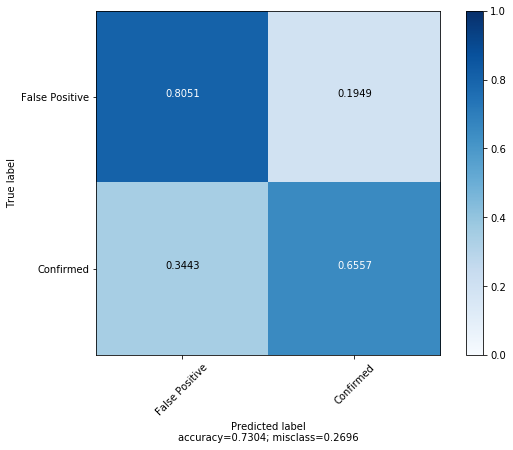

{'Precision raw': array([0.81295547, 0.64421669]),
 'Recall raw': array([0.80513232, 0.6557377 ]),
 'F1 raw': array([0.80902498, 0.64992614]),
 'F1 weighted': 0.7533652726853972,
 'F1 macro': 0.7294755623056166,
 'F1 micro': 0.7528675703858185,
 'Confusion Matrix': array([[1004,  243],
        [ 231,  440]])}

In [68]:
#primero con log..

train_model(CNN_all, [x_train_t,x_train_lc], y_train, [x_val_t,x_val_lc], y_val, e=200, BS=128)  #save model

CNN_all = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...

predichos = (CNN_all.predict([x_val_t,x_val_lc])>=0.5)*1
calculate_metrics(y_val, predichos,'...')

### Data augmentation como grados

In [14]:
n = 3

#x_all = channel_1[:,:,:,:n]

#x_all2 = channel_2[:,:,:,:n]

x_aux = []
for value in range(n):
    x_aux.append(channel_1[mask_train,:,:,value])
x_train = np.concatenate(x_aux)

y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_train = np.tile(y_train, (n))


x_val = channel_1[mask_test,:,:,0]
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

if len(x_train.shape) < 4:
    x_train = np.expand_dims(x_train, axis=-1)
    x_val = np.expand_dims(x_val, axis=-1)

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (13017, 32, 32, 1) (13017,)
Objetos de validación: (1918, 32, 32, 1) (1918,)


In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)  

Instructions for updating:
Use tf.cast instead.
Train on 11715 samples, validate on 1302 samples
Epoch 1/200
11715/11715 [==============================] - 3s 277us/step - loss: 0.5837 - acc: 0.6305 - val_loss: 0.5900 - val_acc: 0.6444
Epoch 2/200
11715/11715 [==============================] - 3s 230us/step - loss: 0.5637 - acc: 0.6338 - val_loss: 0.5843 - val_acc: 0.6482
Epoch 3/200
11715/11715 [==============================] - 3s 239us/step - loss: 0.5558 - acc: 0.6387 - val_loss: 0.5765 - val_acc: 0.6352
Epoch 4/200
11715/11715 [==============================] - 3s 230us/step - loss: 0.5500 - acc: 0.6490 - val_loss: 0.5744 - val_acc: 0.6436
Epoch 5/200
11715/11715 [==============================] - 3s 231us/step - loss: 0.5455 - acc: 0.6542 - val_loss: 0.5725 - val_acc: 0.6183
Epoch 6/200
11715/11715 [==============================] - 3s 233us/step - loss: 0.5429 - acc: 0.6603 - val_loss: 0.5678 - val_acc: 0.6290
Epoch 7/200
11715/11715 [==============================] - 3s 226us/s

Epoch 67/200
11715/11715 [==============================] - 3s 214us/step - loss: 0.4787 - acc: 0.7252 - val_loss: 0.5205 - val_acc: 0.6805
Epoch 68/200
11715/11715 [==============================] - 3s 215us/step - loss: 0.4788 - acc: 0.7217 - val_loss: 0.5200 - val_acc: 0.6805
Epoch 69/200
11715/11715 [==============================] - 3s 217us/step - loss: 0.4822 - acc: 0.7199 - val_loss: 0.5209 - val_acc: 0.6859
Epoch 70/200
11715/11715 [==============================] - 2s 213us/step - loss: 0.4757 - acc: 0.7186 - val_loss: 0.5137 - val_acc: 0.6697
Epoch 71/200
11715/11715 [==============================] - 3s 225us/step - loss: 0.4788 - acc: 0.7223 - val_loss: 0.5156 - val_acc: 0.6843
Epoch 72/200
11715/11715 [==============================] - 3s 222us/step - loss: 0.4793 - acc: 0.7202 - val_loss: 0.5154 - val_acc: 0.6820
Epoch 73/200
11715/11715 [==============================] - 3s 216us/step - loss: 0.4778 - acc: 0.7187 - val_loss: 0.5151 - val_acc: 0.6866
Epoch 74/200
11715/1

Epoch 101/200
11715/11715 [==============================] - 3s 216us/step - loss: 0.4594 - acc: 0.7389 - val_loss: 0.5146 - val_acc: 0.6782
Epoch 102/200
11715/11715 [==============================] - 3s 227us/step - loss: 0.4639 - acc: 0.7354 - val_loss: 0.5135 - val_acc: 0.6813
Epoch 103/200
11715/11715 [==============================] - 3s 226us/step - loss: 0.4562 - acc: 0.7414 - val_loss: 0.5056 - val_acc: 0.6866
Epoch 104/200
11715/11715 [==============================] - 3s 224us/step - loss: 0.4619 - acc: 0.7399 - val_loss: 0.5130 - val_acc: 0.6859
Epoch 105/200
11715/11715 [==============================] - 3s 218us/step - loss: 0.4648 - acc: 0.7304 - val_loss: 0.5134 - val_acc: 0.6728
Epoch 106/200
11715/11715 [==============================] - 2s 208us/step - loss: 0.4600 - acc: 0.7442 - val_loss: 0.5124 - val_acc: 0.6828
Epoch 107/200
11715/11715 [==============================] - 2s 208us/step - loss: 0.4542 - acc: 0.7410 - val_loss: 0.5188 - val_acc: 0.6690
Epoch 108/200

Epoch 135/200
11715/11715 [==============================] - 3s 215us/step - loss: 0.4471 - acc: 0.7485 - val_loss: 0.5149 - val_acc: 0.6774
Epoch 136/200
11715/11715 [==============================] - 3s 223us/step - loss: 0.4456 - acc: 0.7497 - val_loss: 0.5125 - val_acc: 0.6759
Epoch 137/200
11715/11715 [==============================] - 3s 217us/step - loss: 0.4462 - acc: 0.7478 - val_loss: 0.5080 - val_acc: 0.6905
Epoch 138/200
11715/11715 [==============================] - 3s 217us/step - loss: 0.4446 - acc: 0.7548 - val_loss: 0.5163 - val_acc: 0.6759
Epoch 139/200
11715/11715 [==============================] - 2s 213us/step - loss: 0.4414 - acc: 0.7548 - val_loss: 0.5040 - val_acc: 0.6982
Epoch 140/200
11715/11715 [==============================] - 3s 214us/step - loss: 0.4457 - acc: 0.7516 - val_loss: 0.5087 - val_acc: 0.6874
Epoch 141/200
11715/11715 [==============================] - 3s 215us/step - loss: 0.4436 - acc: 0.7542 - val_loss: 0.5070 - val_acc: 0.6959
Epoch 142/200

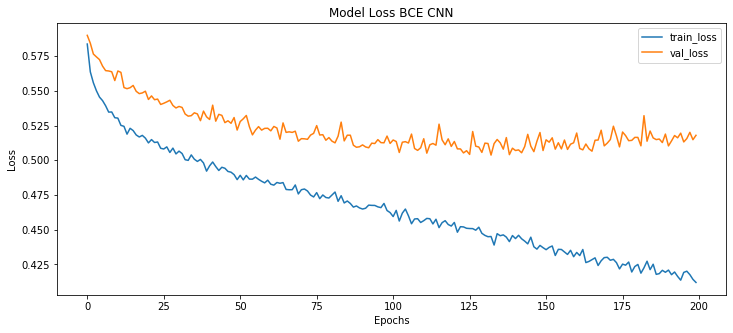

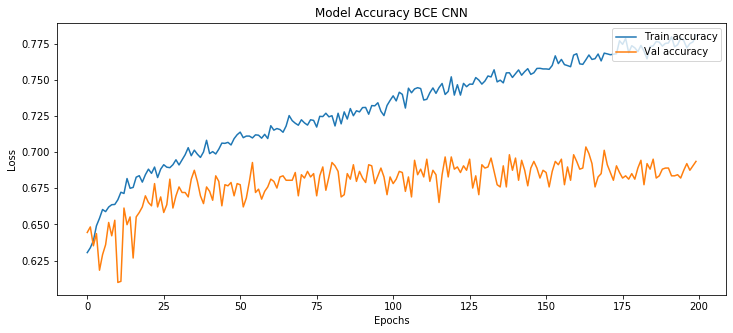

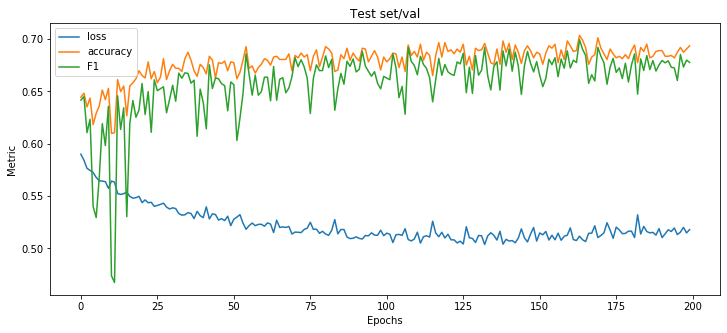

In [16]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.850806,0.676824,0.753908,0.719298,0.704443,0.712722
Confirmed,0.564795,0.779434,0.654978,0.719298,0.704443,0.712722


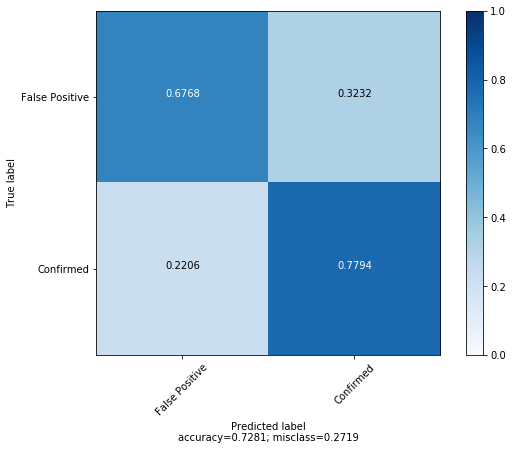

{'Precision raw': array([0.85080645, 0.56479482]),
 'Recall raw': array([0.67682438, 0.77943368]),
 'F1 raw': array([0.75390799, 0.65497808]),
 'F1 weighted': 0.7192979998010819,
 'F1 macro': 0.7044430392738954,
 'F1 micro': 0.7127215849843588,
 'Confusion Matrix': array([[844, 403],
        [148, 523]])}

In [17]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

Epoch 29/200
11715/11715 [==============================] - 2s 186us/step - loss: 0.4825 - acc: 0.7239 - val_loss: 0.5416 - val_acc: 0.6521
Epoch 30/200
11715/11715 [==============================] - 2s 186us/step - loss: 0.4783 - acc: 0.7182 - val_loss: 0.5309 - val_acc: 0.6598
Epoch 31/200
11715/11715 [==============================] - 2s 187us/step - loss: 0.4739 - acc: 0.7209 - val_loss: 0.5491 - val_acc: 0.6636
Epoch 32/200
11715/11715 [==============================] - 2s 179us/step - loss: 0.4728 - acc: 0.7239 - val_loss: 0.5369 - val_acc: 0.6667
Epoch 33/200
11715/11715 [==============================] - 2s 182us/step - loss: 0.4735 - acc: 0.7194 - val_loss: 0.5224 - val_acc: 0.6728
Epoch 34/200
11715/11715 [==============================] - 2s 183us/step - loss: 0.4724 - acc: 0.7286 - val_loss: 0.5280 - val_acc: 0.6644
Epoch 35/200
11715/11715 [==============================] - 2s 180us/step - loss: 0.4706 - acc: 0.7267 - val_loss: 0.5228 - val_acc: 0.6705
Epoch 36/200
11715/1

Epoch 63/200
11715/11715 [==============================] - 2s 192us/step - loss: 0.4136 - acc: 0.7748 - val_loss: 0.5269 - val_acc: 0.6874
Epoch 64/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.4100 - acc: 0.7826 - val_loss: 0.5506 - val_acc: 0.6682
Epoch 65/200
11715/11715 [==============================] - 2s 180us/step - loss: 0.4101 - acc: 0.7807 - val_loss: 0.5835 - val_acc: 0.6567
Epoch 66/200
11715/11715 [==============================] - 2s 189us/step - loss: 0.4106 - acc: 0.7843 - val_loss: 0.5186 - val_acc: 0.6920
Epoch 67/200
11715/11715 [==============================] - 2s 187us/step - loss: 0.4068 - acc: 0.7827 - val_loss: 0.5727 - val_acc: 0.6659
Epoch 68/200
11715/11715 [==============================] - 2s 185us/step - loss: 0.4054 - acc: 0.7882 - val_loss: 0.5721 - val_acc: 0.6575
Epoch 69/200
11715/11715 [==============================] - 2s 181us/step - loss: 0.4012 - acc: 0.7887 - val_loss: 0.5474 - val_acc: 0.6767
Epoch 70/200
11715/1

Epoch 97/200
11715/11715 [==============================] - 2s 182us/step - loss: 0.3159 - acc: 0.8499 - val_loss: 0.6601 - val_acc: 0.6805
Epoch 98/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.3202 - acc: 0.8493 - val_loss: 0.6456 - val_acc: 0.6667
Epoch 99/200
11715/11715 [==============================] - 2s 197us/step - loss: 0.3199 - acc: 0.8510 - val_loss: 0.5951 - val_acc: 0.6836
Epoch 100/200
11715/11715 [==============================] - 2s 186us/step - loss: 0.3165 - acc: 0.8529 - val_loss: 0.6773 - val_acc: 0.6659
Epoch 101/200
11715/11715 [==============================] - 2s 182us/step - loss: 0.3105 - acc: 0.8521 - val_loss: 0.7011 - val_acc: 0.6705
Epoch 102/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.3072 - acc: 0.8598 - val_loss: 0.7042 - val_acc: 0.6667
Epoch 103/200
11715/11715 [==============================] - 2s 187us/step - loss: 0.2994 - acc: 0.8631 - val_loss: 0.6702 - val_acc: 0.6774
Epoch 104/200
11

Epoch 131/200
11715/11715 [==============================] - 2s 193us/step - loss: 0.2319 - acc: 0.9014 - val_loss: 0.8173 - val_acc: 0.6805
Epoch 132/200
11715/11715 [==============================] - 2s 187us/step - loss: 0.2218 - acc: 0.9064 - val_loss: 0.8608 - val_acc: 0.6751
Epoch 133/200
11715/11715 [==============================] - 2s 179us/step - loss: 0.2174 - acc: 0.9076 - val_loss: 0.7996 - val_acc: 0.6667
Epoch 134/200
11715/11715 [==============================] - 2s 190us/step - loss: 0.2244 - acc: 0.9037 - val_loss: 0.8563 - val_acc: 0.6782
Epoch 135/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.2183 - acc: 0.9075 - val_loss: 0.8779 - val_acc: 0.6705
Epoch 136/200
11715/11715 [==============================] - 2s 185us/step - loss: 0.2131 - acc: 0.9142 - val_loss: 0.7871 - val_acc: 0.6805
Epoch 137/200
11715/11715 [==============================] - 2s 188us/step - loss: 0.2202 - acc: 0.9079 - val_loss: 0.8297 - val_acc: 0.6797
Epoch 138/200

Epoch 165/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.1481 - acc: 0.9441 - val_loss: 1.1102 - val_acc: 0.6851
Epoch 166/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.1460 - acc: 0.9437 - val_loss: 1.1923 - val_acc: 0.6705
Epoch 167/200
11715/11715 [==============================] - 2s 184us/step - loss: 0.1453 - acc: 0.9433 - val_loss: 1.1940 - val_acc: 0.6782
Epoch 168/200
11715/11715 [==============================] - 2s 181us/step - loss: 0.1448 - acc: 0.9427 - val_loss: 1.1632 - val_acc: 0.6728
Epoch 169/200
11715/11715 [==============================] - 2s 181us/step - loss: 0.1373 - acc: 0.9477 - val_loss: 1.1149 - val_acc: 0.6774
Epoch 170/200
11715/11715 [==============================] - 2s 180us/step - loss: 0.1388 - acc: 0.9485 - val_loss: 1.0493 - val_acc: 0.6920
Epoch 171/200
11715/11715 [==============================] - 2s 182us/step - loss: 0.1325 - acc: 0.9489 - val_loss: 1.3585 - val_acc: 0.6728
Epoch 172/200

Epoch 199/200
11715/11715 [==============================] - 2s 185us/step - loss: 0.0943 - acc: 0.9665 - val_loss: 1.3870 - val_acc: 0.6897
Epoch 200/200
11715/11715 [==============================] - 2s 186us/step - loss: 0.0986 - acc: 0.9633 - val_loss: 1.5764 - val_acc: 0.6767


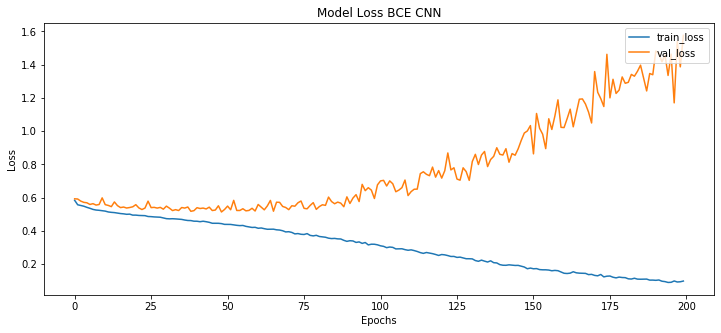

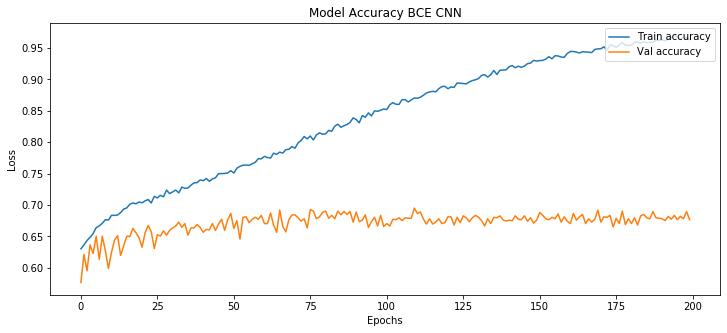

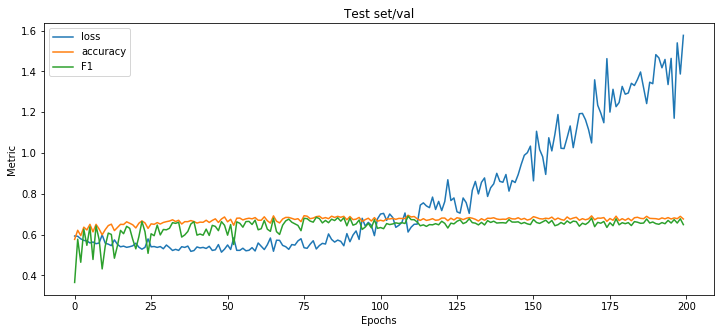

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.837963,0.725742,0.777826,0.735692,0.717607,0.730448
Confirmed,0.591885,0.739195,0.657389,0.735692,0.717607,0.730448


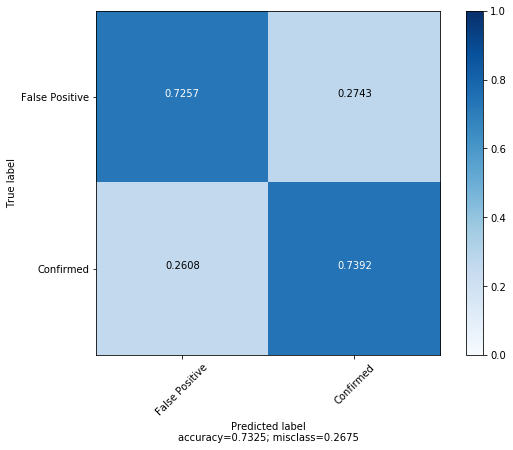

{'Precision raw': array([0.83796296, 0.59188544]),
 'Recall raw': array([0.72574178, 0.73919523]),
 'F1 raw': array([0.77782553, 0.657389  ]),
 'F1 weighted': 0.7356915797769271,
 'F1 macro': 0.717607262883094,
 'F1 micro': 0.7304483837330553,
 'Confusion Matrix': array([[905, 342],
        [175, 496]])}

In [19]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)         73856     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.837963,0.725742,0.777826,0.735692,0.717607,0.730448
Confirmed,0.591885,0.739195,0.657389,0.735692,0.717607,0.730448


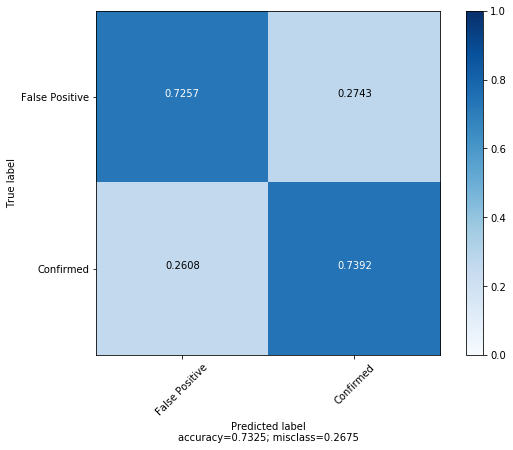

{'Precision raw': array([0.83796296, 0.59188544]),
 'Recall raw': array([0.72574178, 0.73919523]),
 'F1 raw': array([0.77782553, 0.657389  ]),
 'F1 weighted': 0.7356915797769271,
 'F1 macro': 0.717607262883094,
 'F1 micro': 0.7304483837330553,
 'Confusion Matrix': array([[905, 342],
        [175, 496]])}

In [21]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         73856     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.837963,0.725742,0.777826,0.735692,0.717607,0.730448
Confirmed,0.591885,0.739195,0.657389,0.735692,0.717607,0.730448


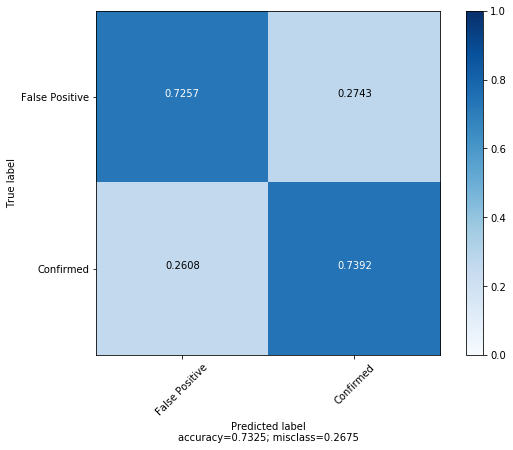

{'Precision raw': array([0.83796296, 0.59188544]),
 'Recall raw': array([0.72574178, 0.73919523]),
 'F1 raw': array([0.77782553, 0.657389  ]),
 'F1 weighted': 0.7356915797769271,
 'F1 macro': 0.717607262883094,
 'F1 micro': 0.7304483837330553,
 'Confusion Matrix': array([[905, 342],
        [175, 496]])}

In [23]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double